In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import xgboost
import sklearn
debug_mode = True
gc.collect()

0

# load data

In [2]:
train = pd.read_feather('../data/train_data.feather')
if debug_mode == True:
    train = train.sample(int(len(train)*0.10))
test = pd.read_feather('../data/test_data.feather')
print(train.shape,test.shape)
df = train.append(test).reset_index(drop=True)
print(df.shape)
display(df)

(3247565, 54) (500000, 54)
(3747565, 54)


,index,dt,chid,shop_tag,txn_cnt,txn_amt,domestic_offline_cnt,domestic_online_cnt,overseas_offline_cnt,overseas_online_cnt,...,masts,educd,trdtp,naty,poscd,cuorg,slam,gender_code,age,primary_card
0,5235157,5.0,10361132.0,15,1.0,18803.137445,1.0,0.0,0.0,0.0,...,1.0,3.0,10.0,1.0,99.0,30.0,116744.107679,1.0,6.0,1.0
1,23557167,19.0,10161507.0,48,1.0,2963.791957,0.0,0.0,0.0,1.0,...,2.0,3.0,15.0,1.0,99.0,30.0,53339.928323,1.0,3.0,1.0
2,16825019,14.0,10130176.0,36,2.0,3998.564726,0.0,2.0,0.0,0.0,...,2.0,3.0,5.0,1.0,5.0,30.0,65680.229561,1.0,2.0,1.0
3,2551951,3.0,10309250.0,9,1.0,7560.706118,0.0,1.0,0.0,0.0,...,2.0,3.0,8.0,1.0,2.0,30.0,211320.046462,0.0,4.0,1.0
4,762487,1.0,10158717.0,38,1.0,17270.231286,0.0,0.0,0.0,1.0,...,1.0,4.0,15.0,1.0,99.0,30.0,65971.240438,0.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3747560,499995,1.0,10306817.0,10,1.0,8038.265093,0.0,1.0,0.0,0.0,...,1.0,2.0,8.0,1.0,2.0,30.0,95982.822967,0.0,4.0,1.0
3747561,499996,1.0,10483487.0,41,1.0,10567.025245,0.0,1.0,0.0,0.0,...,1.0,5.0,11.0,1.0,2.0,30.0,82203.126286,1.0,4.0,1.0
3747562,499997,1.0,10218632.0,33,1.0,6308.563642,1.0,0.0,0.0,0.0,...,2.0,3.0,11.0,1.0,2.0,30.0,71382.709400,0.0,4.0,1.0
3747563,499998,1.0,10146871.0,48,1.0,5773.036485,1.0,0.0,0.0,0.0,...,2.0,3.0,11.0,1.0,2.0,30.0,68561.179121,0.0,3.0,1.0


# 處理缺失值

In [3]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
miss_table = missing_values_table(df)
miss_table

Your selected dataframe has 54 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
slam,200983,5.4
gender_code,48811,1.3
age,48811,1.3
trdtp,41,0.0
educd,2,0.0
masts,1,0.0
naty,1,0.0
poscd,1,0.0
cuorg,1,0.0


In [4]:
train_miss = missing_values_table(train)
print(train.shape)
train_miss

Your selected dataframe has 54 columns.
There are 9 columns that have missing values.
(3247565, 54)


,Missing Values,% of Total Values
slam,172079,5.3
gender_code,41522,1.3
age,41522,1.3
trdtp,41,0.0
educd,2,0.0
masts,1,0.0
naty,1,0.0
poscd,1,0.0
cuorg,1,0.0


In [5]:
test_miss = missing_values_table(test)
print(test.shape)
test_miss

Your selected dataframe has 54 columns.
There are 3 columns that have missing values.
(500000, 54)


,Missing Values,% of Total Values
slam,28904,5.8
gender_code,7289,1.5
age,7289,1.5


In [6]:
miss_table.loc[set(train_miss.index)-set(test_miss.index)]

,Missing Values,% of Total Values
naty,1,0.0
masts,1,0.0
cuorg,1,0.0
educd,2,0.0
poscd,1,0.0
trdtp,41,0.0


In [7]:
row_drop_columns = list(set(train_miss.index)-set(test_miss.index))
row_drop_columns

['naty', 'masts', 'cuorg', 'educd', 'poscd', 'trdtp']

In [8]:
# row axis drop
train = train.dropna(subset=row_drop_columns,axis=0)
test = test.dropna(subset=row_drop_columns,axis=0)
gc.collect()

123

In [9]:
train_miss = missing_values_table(train)
print(train.shape)
train_miss

Your selected dataframe has 54 columns.
There are 3 columns that have missing values.
(3247523, 54)


,Missing Values,% of Total Values
slam,172078,5.3
gender_code,41511,1.3
age,41511,1.3


In [10]:
test_miss = missing_values_table(test)
print(test.shape)
test_miss

Your selected dataframe has 54 columns.
There are 3 columns that have missing values.
(500000, 54)


,Missing Values,% of Total Values
slam,28904,5.8
gender_code,7289,1.5
age,7289,1.5


In [11]:
test[test_miss.index].describe()

,slam,gender_code,age
count,4.710960e+05,492711.000000,492711.000000
mean,3.917144e+105,0.453753,3.889239
std,1.552254e+108,0.497857,1.160498
min,1.299146e+04,0.000000,1.000000
25%,5.970151e+04,0.000000,3.000000
50%,7.822147e+04,0.000000,4.000000
75%,1.023826e+05,1.000000,5.000000
max,6.151170e+110,1.000000,9.000000


In [12]:
list(set(train_miss.index)&set(test_miss.index))

['slam', 'age', 'gender_code']

In [13]:
# use mean value fill na
for col in list(set(train_miss.index)&set(test_miss.index)):
    value = df[col].mean()
    train[col].fillna(value,inplace=True)
    test[col].fillna(value,inplace=True)
    print(f'{col} fill done!')
    gc.collect()

slam fill done!
age fill done!
gender_code fill done!


# 確認所有缺失值處理完畢

In [14]:
train_miss = missing_values_table(train)
print(train.shape)
train_miss

Your selected dataframe has 54 columns.
There are 0 columns that have missing values.
(3247523, 54)


,Missing Values,% of Total Values


In [15]:
test_miss = missing_values_table(test)
print(test.shape)
test_miss

Your selected dataframe has 54 columns.
There are 0 columns that have missing values.
(500000, 54)


,Missing Values,% of Total Values


# 特徵工程
groupby chid 然後去計算對於 shop_tag(以及其他類別欄位的) 的 nunique,norm_count

In [16]:
gc.collect()

63

In [17]:
def agg_function(df,group_var,features):
    agg = df[features+[group_var]].groupby(group_var).agg(["nunique"]).reset_index()
    columns = [group_var]
    for var in agg.columns.levels[0]:
      if var != group_var:
        for stat in agg.columns.levels[1][:-1]:
          columns.append('%s_%s_%s' % (group_var,var,stat))
    agg.columns = columns
    return agg

def count_categorical(df, group_var,categorical_features):
    categorical = pd.get_dummies(df[categorical_features],columns=categorical_features)
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['mean'])
    column_names = []
    for var in categorical.columns.levels[0]:
      for stat in ['norm_count']:
        column_names.append('%s_%s_%s' % (group_var, var, stat))
    categorical.columns = column_names
    return categorical

In [18]:
# 每經過一到特徵工程 看新增多少特徵
print(gc.collect())
categorical_features = ['masts','educd','trdtp','naty','poscd','cuorg','gender_code','age','primary_card']
categorical_features_and_y = categorical_features+['shop_tag']
for col in tqdm(categorical_features_and_y):
    df = df.merge(agg_function(df,'chid',[col]),on='chid',how='left') # chid對col計算nunique
    gc.collect() # 避免記憶體爆掉
    print(col,df.shape)
    df = df.merge(count_categorical(df,'chid',[col]),on='chid',how='left') # chid對col計算norm_count
    gc.collect() # 避免記憶體爆掉
    print(col,df.shape)

  0%|          | 0/10 [00:00<?, ?it/s]

21
masts (3747565, 55)


 10%|█         | 1/10 [00:12<01:52, 12.48s/it]

masts (3747565, 58)
educd (3747565, 59)


 20%|██        | 2/10 [00:28<01:47, 13.39s/it]

educd (3747565, 65)
trdtp (3747565, 66)


 30%|███       | 3/10 [00:52<01:57, 16.83s/it]

trdtp (3747565, 95)
naty (3747565, 96)


 40%|████      | 4/10 [01:17<01:54, 19.13s/it]

naty (3747565, 98)
poscd (3747565, 99)


 50%|█████     | 5/10 [01:46<01:50, 22.09s/it]

poscd (3747565, 109)
cuorg (3747565, 110)


 60%|██████    | 6/10 [02:23<01:46, 26.69s/it]

cuorg (3747565, 144)
gender_code (3747565, 145)


 70%|███████   | 7/10 [03:19<01:46, 35.49s/it]

gender_code (3747565, 147)
age (3747565, 148)


 80%|████████  | 8/10 [04:18<01:25, 42.57s/it]

age (3747565, 157)
primary_card (3747565, 158)


 90%|█████████ | 9/10 [05:19<00:47, 47.87s/it]

primary_card (3747565, 160)
shop_tag (3747565, 161)


100%|██████████| 10/10 [06:36<00:00, 39.65s/it]

shop_tag (3747565, 210)


# 將df拆回train and test

In [19]:
# 記得上面寫的是 df = train.append(test).reset_index(drop=True) test就是後面500000筆
print(gc.collect())
train = df.iloc[:-500000]
test = df.iloc[-500000:]
del df
print(gc.collect())
print(train.shape,test.shape)

44
0
(3247565, 210) (500000, 210)


# 篩選特徵

In [20]:
# 看一下有哪些欄位
train.columns

Index(['index', 'dt', 'chid', 'shop_tag', 'txn_cnt', 'txn_amt',
       'domestic_offline_cnt', 'domestic_online_cnt', 'overseas_offline_cnt',
       'overseas_online_cnt',
       ...
       'chid_shop_tag_45_norm_count', 'chid_shop_tag_46_norm_count',
       'chid_shop_tag_47_norm_count', 'chid_shop_tag_48_norm_count',
       'chid_shop_tag_5_norm_count', 'chid_shop_tag_6_norm_count',
       'chid_shop_tag_7_norm_count', 'chid_shop_tag_8_norm_count',
       'chid_shop_tag_9_norm_count', 'chid_shop_tag_other_norm_count'],
      dtype='object', length=210)

In [21]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRFClassifier

v = train.sample(4200) # 減少計算時間(取n筆就好)
X = v.drop(['index','shop_tag'],axis=1) # 去除索引(index)和y('shop_tag')
y = v['shop_tag']
selector = SelectFromModel(estimator=XGBRFClassifier(objective='multi:softmax')).fit(X, y) #多分類任務objective='multi:softmax'

# 根據model計算特徵score
res = pd.DataFrame(dict(zip(X.columns,selector.estimator_.feature_importances_)),index=[*range(len(X.columns))]).T[[0]]
res.columns = ['score']
res = res.sort_values(by='score',ascending=False)
del X
del y
print(gc.collect())
res.head(20)

C:\Users\ricky\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0


,score
card_4_txn_amt_pct,0.065531
chid_shop_tag_37_norm_count,0.047918
overseas_online_amt_pct,0.043805
domestic_online_cnt,0.032382
chid_shop_tag_12_norm_count,0.029458
chid_shop_tag_45_norm_count,0.027465
card_4_txn_cnt,0.024796
chid_shop_tag_other_norm_count,0.023350
chid_shop_tag_48_norm_count,0.021377
overseas_online_cnt,0.020648


In [22]:
print(res.shape)

(208, 1)


# 

In [23]:
# 篩選前k名特徵
k = 42
k_feats = res.head(k).index.tolist()
train = train[k_feats+['index']+['shop_tag']]
test = test[k_feats+['index']]
print(train.shape,test.shape)

(3247565, 44) (500000, 43)


# 處裡共線性問題

In [24]:
corrs = abs(train.corr())
threshold = 0.8
above_threshold_vars = {}
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [25]:
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []
for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  2


In [26]:
train = train.drop(cols_to_remove,axis=1)
test = test.drop(cols_to_remove,axis=1)

<AxesSubplot:>

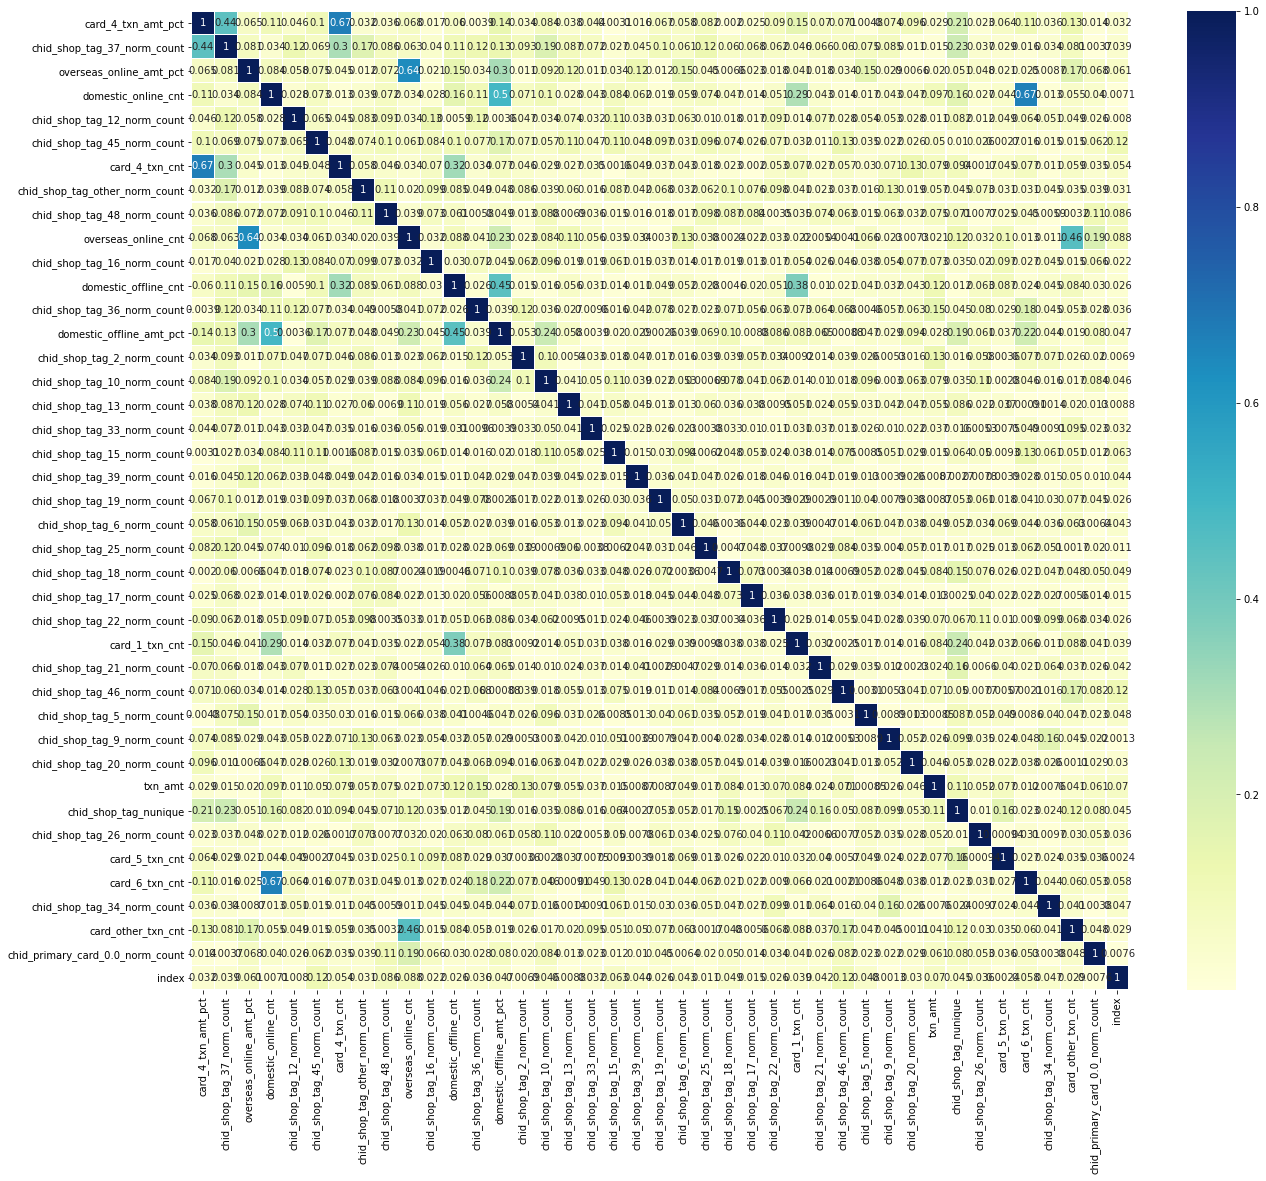

In [28]:
fig = plt.figure(figsize=(21,18))
sns.heatmap(abs(train.sample(420).corr()),annot=True,linewidths=0.1,cmap='YlGnBu')

# final check data

In [29]:
train = train.reset_index(drop=True)
print(train.shape)
print(train.isnull().sum().sum())
train.head()

(3247565, 42)
0


,card_4_txn_amt_pct,chid_shop_tag_37_norm_count,overseas_online_amt_pct,domestic_online_cnt,chid_shop_tag_12_norm_count,chid_shop_tag_45_norm_count,card_4_txn_cnt,chid_shop_tag_other_norm_count,chid_shop_tag_48_norm_count,overseas_online_cnt,...,txn_amt,chid_shop_tag_nunique,chid_shop_tag_26_norm_count,card_5_txn_cnt,card_6_txn_cnt,chid_shop_tag_34_norm_count,card_other_txn_cnt,chid_primary_card_0.0_norm_count,index,shop_tag
0,0.0,0.083333,0.0,0.0,0.000000,0.000000,0.0,0.250000,0.000000,0.0,...,18803.137445,7,0.000000,0.0,0.0,0.083333,0.0,0,5235157,15
1,0.0,0.210526,1.0,0.0,0.052632,0.000000,0.0,0.105263,0.105263,1.0,...,2963.791957,11,0.000000,0.0,0.0,0.000000,0.0,0,23557167,48
2,0.0,0.000000,0.0,2.0,0.000000,0.000000,0.0,0.428571,0.000000,0.0,...,3998.564726,5,0.142857,0.0,0.0,0.000000,2.0,0,16825019,36
3,0.0,0.071429,0.0,1.0,0.000000,0.000000,0.0,0.071429,0.357143,0.0,...,7560.706118,10,0.000000,0.0,0.0,0.000000,0.0,0,2551951,9
4,1.0,0.333333,1.0,0.0,0.000000,0.222222,1.0,0.000000,0.000000,1.0,...,17270.231286,6,0.000000,0.0,0.0,0.000000,0.0,0,762487,38


In [30]:
test = test.reset_index(drop=True)
print(test.shape)
print(test.isnull().sum().sum())
test.head()

(500000, 41)
0


,card_4_txn_amt_pct,chid_shop_tag_37_norm_count,overseas_online_amt_pct,domestic_online_cnt,chid_shop_tag_12_norm_count,chid_shop_tag_45_norm_count,card_4_txn_cnt,chid_shop_tag_other_norm_count,chid_shop_tag_48_norm_count,overseas_online_cnt,...,chid_shop_tag_20_norm_count,txn_amt,chid_shop_tag_nunique,chid_shop_tag_26_norm_count,card_5_txn_cnt,card_6_txn_cnt,chid_shop_tag_34_norm_count,card_other_txn_cnt,chid_primary_card_0.0_norm_count,index
0,1.0,0.600000,0.0,0.0,0.0,0.200000,3.0,0.100000,0.000000,0.0,...,0.0,3891.965283,4,0.000000,0.0,0.0,0.100000,0.0,0,0
1,0.0,0.000000,0.0,0.0,0.0,0.083333,0.0,0.138889,0.138889,0.0,...,0.0,10616.561549,13,0.000000,0.0,0.0,0.000000,0.0,0,1
2,0.0,0.214286,0.0,2.0,0.0,0.000000,0.0,0.071429,0.071429,0.0,...,0.0,23527.655416,10,0.000000,0.0,0.0,0.071429,0.0,0,2
3,0.0,0.117647,0.0,2.0,0.0,0.117647,0.0,0.000000,0.117647,0.0,...,0.0,17751.558260,13,0.058824,0.0,0.0,0.000000,0.0,0,3
4,1.0,0.000000,0.0,0.0,0.5,0.000000,1.0,0.000000,0.000000,0.0,...,0.0,21701.307598,2,0.000000,0.0,0.0,0.000000,0.0,1,4


# save data

In [31]:
train.to_feather("../data/train_preprocessed.feather")
test.to_feather("../data/test_preprocessed.feather")
print('save done!')

save done!
